# Neural Netowrk and Deep Learning 2019/2020: Homework 1

Clara Eminente 

ID number: 1205689

Physics of Data, University of Padua

# Import data and training with cross validation

In [1]:
import pandas as pd
import csv
import warnings
import warnings
warnings.filterwarnings('ignore')
import time

#importing custom module
from NN_H1 import *

np.random.seed(20)

Shape of the training dataset: (120, 2)
Shape of the training dataset: (25, 2)


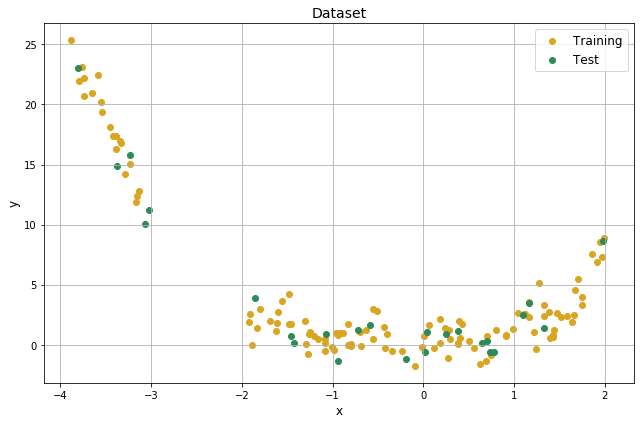

In [2]:
train_data = np.loadtxt("training_set.txt", delimiter=",")
print("Shape of the training dataset:", train_data.shape)
x_train_tot, y_train_tot = get_XY(train_data)

test_data = np.loadtxt("test_set.txt", delimiter=",")
print("Shape of the training dataset:", test_data.shape)
x_test, y_test = get_XY(test_data)

fig, ax = plt.subplots(1,1, figsize=(9,6))
ax.scatter(x_train_tot, y_train_tot, color="goldenrod", label="Training")
ax.scatter(x_test, y_test, color="seagreen", label="Test")
ax.set_xlabel("x", fontsize=12)
ax.set_ylabel("y", fontsize=12)
ax.set_title("Dataset", fontsize=14)
ax.legend(fontsize=12)
ax.grid()
fig.tight_layout()
plt.show()

At this point it is important to notice that in order to have a slimmer code a library called NN_H1 was implemented. 

This library contins the optionals (different regularizers and activation functions), the class Network and the implementation of some useful functions, inlcuding a training function.

Briefly the main parts are:


- class Network was modified in order to work even when batches of entries are provided and its weights were adjusted in order to have dimension $(N_{input}, N_{output})$ and not vice versa
- class Network was also modified in order to include choice of regularization term and activation function

## A simple training with cross validation

Cross validation was implemented with the function kfold (in the library NN_H1): the function outputs the indeces of the validation set.

In the following (until the implementation of the random search) the hyperparameters where chosen with no particular care so we do not expect excellent performances.

In [4]:
Ni = 1
Nh1 = 50
Nh2 = 50
No = 1
function = "sig"

batchsize = 1
n_epochs = 5000
lr = 0.01
decay = True
lr_final = 0.001
reg_type = "None" #we will see this feature later
alpha_reg = 0.

n_folds = 4

Iteration on k fold: 0 - Final train loss: 1.15144 - Final validation loss: 0.94566


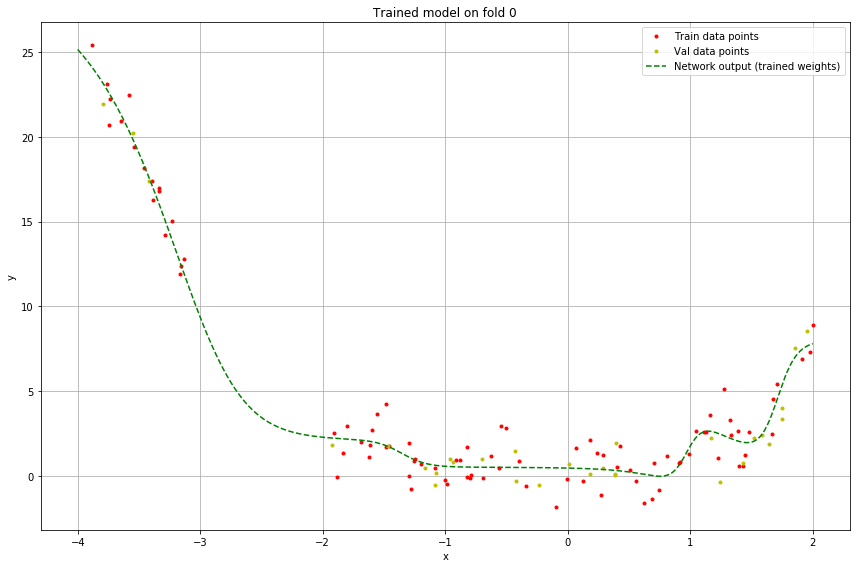

Iteration on k fold: 1 - Final train loss: 1.23680 - Final validation loss: 1.46289


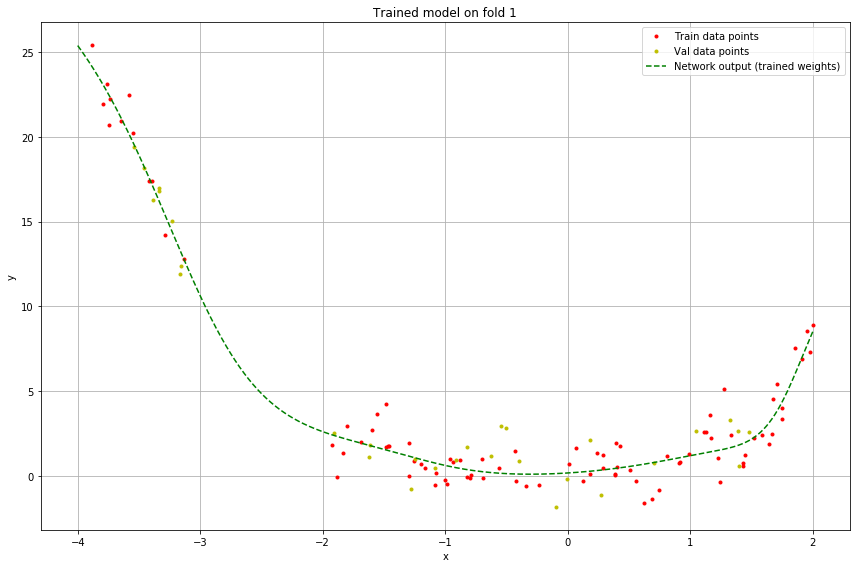

Iteration on k fold: 2 - Final train loss: 1.23803 - Final validation loss: 1.37581


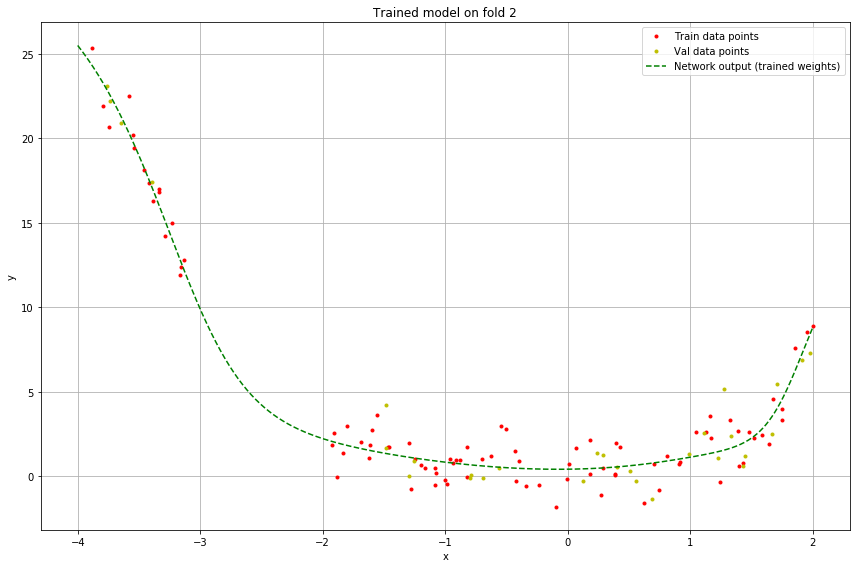

Iteration on k fold: 3 - Final train loss: 1.16814 - Final validation loss: 1.63269


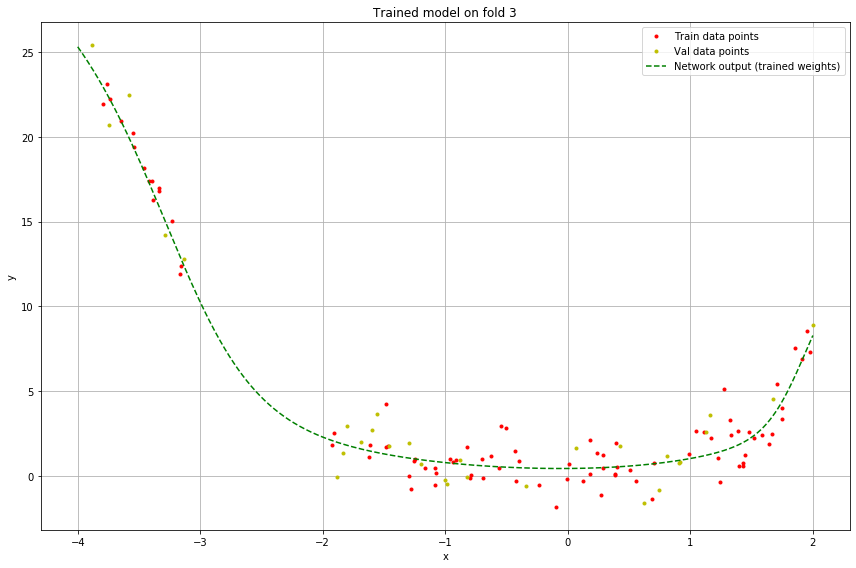

In [5]:
#these are for plotting purposes
mean_train=[]
mean_val=[]


#Preparing folds
folds = kfold(train_data, n_folds, True)

for i in tnrange(n_folds, desc="Folds loop", leave=True):
    
    ##Prepare folds: one fold is used as validation, the rest as traning set
    val_set = train_data[list(folds[i])]
    train_set = np.delete(train_data, folds[i],0)

    ###Initialize network @ each itearation over folds so train starts all over again
    net = Network(Ni, Nh1, Nh2, No, act_f=function)
    
    ###-----------TRAINING-----------###
    train_loss_log = []
    val_loss_log = []

    ###compute dacay given final value and number of epochs
    lr_decay = (lr_final / lr)**(1 / n_epochs) 

    ###set regularization function to none
    reg_term = reg(reg_type, alpha_reg)

    for num_ep in tnrange(n_epochs, desc="Epochs", leave=False):
        # Learning rate decay
        if decay:
            lr *= lr_decay

        ### create batches given batchsize: batches is a list of lists, each one has x and y 
        batches = divide_in_batches(train_set, batchsize) 

        ### train each batch
        train_loss_vec = [net.update(x, y, lr, reg_term) for x, y in batches] 
        ### compute train loss as mean over batch losses 
        #(loss of a single batch is the mean of the losses of that batch )
        train_loss = np.mean(np.array(train_loss_vec))

        ### compute validation loss
        x_val, y_val = get_XY(val_set)
        y_val_est = net.forward(x_val)
        val_loss = np.mean((y_val_est - y_val)**2)
        
        ### Update logs
        train_loss_log.append(train_loss)
        val_loss_log.append(val_loss)
    
    print('Iteration on k fold: %d - Final train loss: %.5f - Final validation loss: %.5f' 
          % (i, train_loss, val_loss))
    
    mean_train.append(train_loss_log)
    mean_val.append(val_loss_log)

    
    ##-----------This could be removed----------------##
    ##These plots show the end of the training and the comparison with actual data 
    x_highres = np.linspace(-4, 2, 1000).reshape(-1,1)
    net_output = net.forward(x_highres)

    ## Plot
    #plt.close('all')
    x_train, y_train = get_XY(train_set)
    x_val, y_val = get_XY(val_set)
    plt.figure(figsize=(12,8))
    plt.plot(x_train, y_train, color='r', ls='', marker='.', label='Train data points')
    plt.plot(x_val, y_val, color='y', ls='', marker='.', label='Val data points')
    plt.plot(x_highres, net_output, color='g', ls='--', label='Network output (trained weights)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title("Trained model on fold "+ str(i))
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    ##-----------------------------------------------##

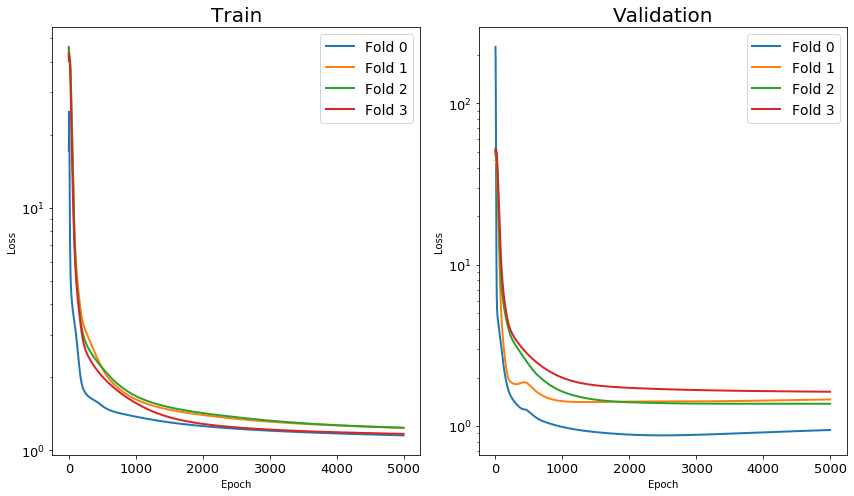

In [10]:
##Plot loss between folds
fig, ax = plt.subplots(1,2, figsize=(12,7))
for i in range(n_folds):
    ax[0].semilogy(mean_train[i], label="Fold "+str(i), linewidth=2)
    ax[1].semilogy(mean_val[i], label="Fold "+str(i), linewidth=2)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[0].set_title("Train", fontsize=20)
ax[1].set_title("Validation", fontsize=20)
ax[0].tick_params(axis='both', which='major', labelsize=13) 
ax[1].tick_params(axis='both', which='major', labelsize=13) 
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)
fig.tight_layout()
fig.show()    

# Early stopping, regularizers and activation functions

In order to avoid overfitting an early stopping procedure was introduced. This was implemented adding the following code to the training part:

```python
#early stopping
if (val_loss < best_val_loss):
    #keeping track of best parameters
    best_val_loss = val_loss
    best_train_loss = train_loss
    best_model = model
    count = 0 #count is reset everytime i get a better performance
elif val_loss >= best_val_loss:
    count += 1
if (count >= patience):
    break
```

where $\textit{patience}$ is the number of epochs during which the validation error increases (or stays the same) and after which the training is stopped.

In [11]:
patience = 250
stopped_list=[]

#these are for plotting purposes
mean_train=[]
mean_val=[]


#Preparing folds
folds = kfold(train_data, n_folds, True)

for i in tnrange(n_folds, desc="Folds loop", leave=True):
    
    ##Prepare folds: one fold is used as validation, the rest as traning set
    val_set = train_data[list(folds[i])]
    train_set = np.delete(train_data, folds[i],0)

    ###Initialize network @ each itearation over folds so train starts all over again
    net = Network(Ni, Nh1, Nh2, No, act_f=function)
    
    ###-----------TRAINING-----------###
    train_loss_log = []
    val_loss_log = []
    
    #early stopping
    best_val_loss = 1000
    stopped = n_epochs-1
    flag = True

    ###compute dacay given final value and number of epochs
    lr_decay = (lr_final / lr)**(1 / n_epochs) 

    ###set regularization function to none
    reg_term = reg(reg_type, alpha_reg)

    for num_ep in tnrange(n_epochs, desc="Epochs", leave=False):
        # Learning rate decay
        if decay:
            lr *= lr_decay

        ### create batches given batchsize: batches is a list of lists, each one has x and y 
        batches = divide_in_batches(train_set, batchsize) 

        ### train each batch
        train_loss_vec = [net.update(x, y, lr, reg_term) for x, y in batches] 
        ### compute train loss as mean over batch losses 
        #(loss of a single batch is the mean of the losses of that batch )
        train_loss = np.mean(np.array(train_loss_vec))

        ### compute validation loss
        x_val, y_val = get_XY(val_set)
        y_val_est = net.forward(x_val)
        val_loss = np.mean((y_val_est - y_val)**2)
        
        ### Update logs
        train_loss_log.append(train_loss)
        val_loss_log.append(val_loss)
        
        #early stopping: in this case the best parameters are retained but the training keeps going on
        #for plotting purpose. The code actually used during training is the pseudocode above.
        if (val_loss <= best_val_loss) and (flag == True):
            best_val_loss = val_loss
            best_train_loss = train_loss
            best_model = net
            count = 0 #count is reset everytime i get a better performance
        elif val_loss > best_val_loss:
            count += 1
        if (count >= patience) and (flag == True):
            #break
            flag = False
            stopped = num_ep
        
        
    print('Iteration on k fold: %d - Stopped at iteration: %d - Final train loss: %.4f - Final validation loss: %.4f' 
          % (i, stopped+1, train_loss, val_loss))
    print('Iteration on k fold: %d - Best validation loss: %.4f' %(i,best_val_loss))
    
    mean_train.append(train_loss_log)
    mean_val.append(val_loss_log)
    stopped_list.append(stopped)

    

Iteration on k fold: 0 - Stopped at iteration: 5000 - Final train loss: 1.2830 - Final validation loss: 1.9392
Iteration on k fold: 0 - Best validation loss: 1.9392


Iteration on k fold: 1 - Stopped at iteration: 5000 - Final train loss: 1.3569 - Final validation loss: 1.1687
Iteration on k fold: 1 - Best validation loss: 1.1687


Iteration on k fold: 2 - Stopped at iteration: 1414 - Final train loss: 1.1886 - Final validation loss: 1.6627
Iteration on k fold: 2 - Best validation loss: 1.5387


Iteration on k fold: 3 - Stopped at iteration: 2179 - Final train loss: 1.2274 - Final validation loss: 1.4717
Iteration on k fold: 3 - Best validation loss: 1.3186



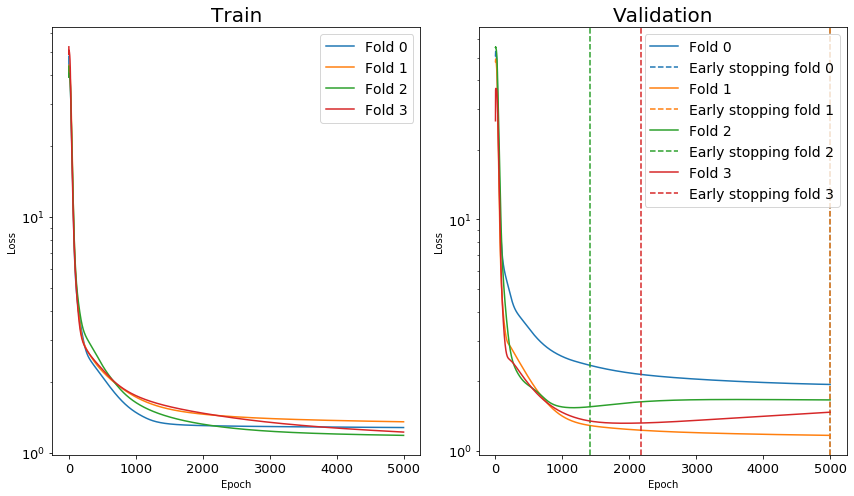

In [13]:
##Plot loss between folds
fig, ax = plt.subplots(1,2, figsize=(12,7))
for i in range(n_folds):
    ax[0].semilogy(mean_train[i], label="Fold "+str(i))
    ax[1].semilogy(mean_val[i], label="Fold "+str(i))
    ax[1].axvline(stopped_list[i]+1, color=plt.gca().lines[-1].get_color(), 
                  label="Early stopping fold "+str(i), linestyle= "--")
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[0].set_title("Train", fontsize=20)
ax[1].set_title("Validation", fontsize=20)
ax[0].tick_params(axis='both', which='major', labelsize=13) 
ax[1].tick_params(axis='both', which='major', labelsize=13) 
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)
fig.tight_layout()
fig.show()    

At this point there are two things left: implementing some optional features (such as more activation functions and regularizers) and implementing a search over the parameters of the model in order to evaluate the best set.

In order to do so (and slim the code) the training procedure (i.e. all the above code) was included in a function, $\textit{train_model}$, included in the module $\textit{NN_H1}$. 

```python
def train_model(model, train_set, val_set, batchsize,
                n_epochs, lr, decay=True, lr_final=0.0001, reg_type=None, 
                alpha_reg=0.0001, patience = 300, return_log=False)
```

As it is possible to notice the training function also integrates the optional parameters, whose implementation is also included in the module $\textit{NN_H1}$.

# Random search and choice of best hyperparameters using cross validation

There are basically two main sets of hyperparameters to choose: the hyperparameters of the network and the training parameters. In particular:

- Network_pars:
    - hidden neurons (Nh1, Nh2)
    - activation_function in ["ReLU", "leaky_ReLU", "sig"]
    
- Training_pars:
    - number of folds (k)
    - batchsize
    - n_epochs
    - learning_rate(lr)
    - learning_rate_decay(decay)
    - final_learning_rate(lr_final)
    - regularizer(reg_type) in ["L1", "L2", "None"]
    - regularizer_parameter(alpha_reg)
    - patience 
    
The following parameters were kept fixed:
```python
Ni=1
No=1
n_folds = 4
n_epochs = 5000
batchsize = 1
decay = True 
lr_final = 0.0005
patience = 300
```

A random search was implemented for the rest of the parameters since trying all combinations would not be feasible.

Each set of hyperparameters (a set is made of both Network and Training parameters) was trained over the k folds and its validation loss of the set was computed as average over all k validation losses. Each set was saved along with its validation loss in a csv file.

After all the sets have been trained (and their validation losses computed) the one with smaller validation loss is picked and trained again in order to obtain the final trained network.

Its performance is then checked over the test set.

In [16]:
#Preparing file to store models and their performances
filename = "Models.csv"

parameters=["Ni","Nh1", "Nh2", "No", "act_f","n_epochs","batchsize", "lr","decay",
            "lr_final", "reg_type", "alpha_reg","patience","train_loss","val_loss"]

list_of_models = pd.DataFrame(columns=parameters)
list_of_models.to_csv(filename,index=False)

n_models = 500

with open(filename,'a',newline='') as f:
    writer=csv.writer(f)
    
    #--------FIXED PARAMETERS-------#
    Ni=1
    No=1
    n_folds = 4
    n_epochs = 5000
    batchsize = 1
    decay = True 
    lr_final = 0.0005
    patience = 400
    
    #PREPARE FOLDS
    folds = kfold(train_data, n_folds, True)
    
    start = time.time()
    
    for nm in tnrange(n_models, desc="Loop over models", leave=True):
        
        ##-----PREPARING HYPERPARAMETERS-----#
        #Network
        Nh1 = np.random.randint(5,100+1)
        Nh2 = Nh1
        function = np.random.choice(["ReLU", "sig", "leaky ReLU"])
        
        #Training
        lr = np.random.random()*(0.01 - 0.001) + 0.001 
        regularizer=np.random.choice(["L1", "L2", "None"])
        alpha_reg= np.random.random()*(0.01 - 0.001) + 0.001


        Network_pars = {"Ni":Ni, "Nh1":Nh1, "Nh2":Nh2, "No":No, "act_f":function}
        Training_pars = {"n_epochs": n_epochs, "batchsize":batchsize, "lr":lr, 
                         "decay":decay, "lr_final":lr_final, "reg_type":regularizer, "alpha_reg":alpha_reg,
                         "patience":patience}

        ##These lists will contain the errors over the folds (error of the model will be the mean)
        val_err_list=[]
        train_err_list=[]

        ##Train model over folds
        for i in tnrange(n_folds, desc="Folds loop", leave=False):

            ##Prepare folds 2 
            val_set = train_data[list(folds[i])]
            train_set = np.delete(train_data, folds[i],0)

            ##Initialize network @ each itearation over folds so train starts all over again
            net = Network(**Network_pars)

            ##Training
            fit_net, train_err, val_err = train_model(net, train_set, val_set, **Training_pars, return_log=False)
            val_err_list.append(val_err)
            train_err_list.append(train_err)

        mean_val_err = np.mean(np.array(val_err_list))
        mean_train_err = np.mean(np.array(train_err_list))
        
        print("Model: %d - Training error: %.4f - Validation error: %.4f" %(nm, mean_train_err, mean_val_err))

        ##Create dictionary with model parameters and losses (train and val) and write it in a csv
        model_dict={**Network_pars,**Training_pars, "train_loss":mean_train_err, "val_loss":mean_val_err}
        writer.writerow(list(model_dict.values()))
    

    
f.close()  

end = time.time()
print("Elapsed time to train %d models: %f s" %(n_models, end-start))

Model: 0 - Training error: 1.7850 - Validation error: 1.4604


Model: 1 - Training error: 1.1857 - Validation error: 1.3134


Model: 2 - Training error: 1.2851 - Validation error: 1.3857


Model: 3 - Training error: 1.0195 - Validation error: 1.2022


Model: 4 - Training error: 1.4368 - Validation error: 1.2352


Model: 5 - Training error: 2.9677 - Validation error: 3.5414


Model: 6 - Training error: 1.3052 - Validation error: 1.4591


Model: 7 - Training error: 1.2014 - Validation error: 1.3322


Model: 8 - Training error: 1.5250 - Validation error: 1.6162


Model: 9 - Training error: 1.0524 - Validation error: 1.2573


Model: 10 - Training error: 1.2743 - Validation error: 1.4183


Model: 11 - Training error: 1.2353 - Validation error: 1.4167


Model: 12 - Training error: 1.4219 - Validation error: 1.2839


Model: 13 - Training error: 1.4452 - Validation error: 1.5139


Model: 14 - Training error: 1.5864 - Validation error: 1.6643


Model: 15 - Training error: 1.0164 - Validation error: 1.2939


Model: 16 - Training error: 1.2670 - Validation error: 1.3340


Model: 17 - Training error: 1.6841 - Validation error: 1.2960


Model: 18 - Training error: 1.2510 - Validation error: 1.3141


Model: 19 - Training error: 1.2208 - Validation error: 1.3518


Model: 20 - Training error: 1.1351 - Validation error: 1.2793


Model: 21 - Training error: 1.6757 - Validation error: 1.4282


Model: 22 - Training error: 1.0156 - Validation error: 1.2384


Model: 23 - Training error: 0.9691 - Validation error: 1.2403


Model: 24 - Training error: 2.6850 - Validation error: 3.1857


Model: 25 - Training error: 1.2962 - Validation error: 1.3357


Model: 26 - Training error: 1.3283 - Validation error: 1.3620


Model: 27 - Training error: 3.5809 - Validation error: 3.5729


Model: 28 - Training error: 0.9953 - Validation error: 1.2447


Model: 29 - Training error: 1.1243 - Validation error: 1.2500


Model: 30 - Training error: 1.4187 - Validation error: 1.2882


Model: 31 - Training error: 1.0962 - Validation error: 1.2197


Model: 32 - Training error: 1.0946 - Validation error: 1.2770


Model: 33 - Training error: 1.1375 - Validation error: 1.2705


Model: 34 - Training error: 1.1767 - Validation error: 1.2830


Model: 35 - Training error: 1.0757 - Validation error: 1.2959


Model: 36 - Training error: 1.2303 - Validation error: 1.4078


Model: 37 - Training error: 3.2822 - Validation error: 2.6953


Model: 38 - Training error: 1.0687 - Validation error: 1.3237


Model: 39 - Training error: 3.1333 - Validation error: 2.9108


Model: 40 - Training error: 1.5135 - Validation error: 1.5960


Model: 41 - Training error: 6.3985 - Validation error: 3.1976


Model: 42 - Training error: 1.3730 - Validation error: 1.3135


Model: 43 - Training error: 2.6380 - Validation error: 1.6809


Model: 44 - Training error: 1.5133 - Validation error: 1.5687


Model: 45 - Training error: 1.3290 - Validation error: 1.3850


Model: 46 - Training error: 3.6246 - Validation error: 3.5920


Model: 47 - Training error: 1.2694 - Validation error: 1.3080


Model: 48 - Training error: 1.5554 - Validation error: 1.3116


Model: 49 - Training error: 1.0452 - Validation error: 1.2803


Model: 50 - Training error: 0.9800 - Validation error: 1.2695


Model: 51 - Training error: 3.5144 - Validation error: 2.3673


Model: 52 - Training error: 1.2192 - Validation error: 1.3361


Model: 53 - Training error: 1.3258 - Validation error: 1.3748


Model: 54 - Training error: 3.6010 - Validation error: 3.5688


Model: 55 - Training error: 1.7026 - Validation error: 1.4566


Model: 56 - Training error: 1.7298 - Validation error: 2.0841


Model: 57 - Training error: 1.4508 - Validation error: 1.4978


Model: 58 - Training error: 1.1491 - Validation error: 1.2209


Model: 59 - Training error: 1.7665 - Validation error: 1.4548


Model: 60 - Training error: 1.1811 - Validation error: 1.2379


Model: 61 - Training error: 1.1973 - Validation error: 1.2407


Model: 62 - Training error: 2.0482 - Validation error: 1.9250


Model: 63 - Training error: 2.1527 - Validation error: 1.7932


Model: 64 - Training error: 1.3614 - Validation error: 1.2656


Model: 65 - Training error: 3.5929 - Validation error: 3.5824


Model: 66 - Training error: 1.0558 - Validation error: 1.3224


Model: 67 - Training error: 1.1718 - Validation error: 1.3184


Model: 68 - Training error: 1.1876 - Validation error: 1.2811


Model: 69 - Training error: 1.7466 - Validation error: 1.4961


Model: 70 - Training error: 1.9965 - Validation error: 2.3358


Model: 71 - Training error: 1.2513 - Validation error: 1.2718


Model: 72 - Training error: 1.5340 - Validation error: 1.5806


Model: 73 - Training error: 1.4627 - Validation error: 1.5449


Model: 74 - Training error: 1.0491 - Validation error: 1.2766


Model: 75 - Training error: 2.4839 - Validation error: 2.2000


Model: 76 - Training error: 3.6396 - Validation error: 3.6016


Model: 77 - Training error: 1.5410 - Validation error: 1.5955


Model: 78 - Training error: 1.2461 - Validation error: 1.1851


Model: 79 - Training error: 1.3258 - Validation error: 1.3669


Model: 80 - Training error: 1.1082 - Validation error: 1.2401


Model: 81 - Training error: 1.1388 - Validation error: 1.2025


Model: 82 - Training error: 1.2044 - Validation error: 1.3377


Model: 83 - Training error: 7.4122 - Validation error: 6.6415


Model: 84 - Training error: 1.3700 - Validation error: 1.2309


Model: 85 - Training error: 1.5710 - Validation error: 1.5965


Model: 86 - Training error: 1.1300 - Validation error: 1.2436


Model: 87 - Training error: 1.0887 - Validation error: 1.2685


Model: 88 - Training error: 1.0443 - Validation error: 1.2441


Model: 89 - Training error: 20.8615 - Validation error: 22.8156


Model: 90 - Training error: 4.6043 - Validation error: 5.8177


Model: 91 - Training error: 1.0101 - Validation error: 1.2409


Model: 92 - Training error: 1.1790 - Validation error: 1.3337


Model: 93 - Training error: 14.5351 - Validation error: 9.8434


Model: 94 - Training error: 1.5670 - Validation error: 1.3691


Model: 95 - Training error: 1.0080 - Validation error: 1.2203


Model: 96 - Training error: 1.6313 - Validation error: 1.5626


Model: 97 - Training error: 3.0821 - Validation error: 3.0525


Model: 98 - Training error: 1.3175 - Validation error: 1.4073


Model: 99 - Training error: 1.4816 - Validation error: 1.2547


Model: 100 - Training error: 1.4649 - Validation error: 1.4430


Model: 101 - Training error: 1.5339 - Validation error: 1.6586


Model: 102 - Training error: 1.2343 - Validation error: 1.3457


Model: 103 - Training error: 1.2233 - Validation error: 1.2889


Model: 104 - Training error: 1.0292 - Validation error: 1.2150


Model: 105 - Training error: 5.9294 - Validation error: 8.5953


Model: 106 - Training error: 1.3005 - Validation error: 1.3798


Model: 107 - Training error: 1.1295 - Validation error: 1.2360


Model: 108 - Training error: 1.0860 - Validation error: 1.2733


Model: 109 - Training error: 1.3462 - Validation error: 1.4044


Model: 110 - Training error: 1.8498 - Validation error: 1.2883


Model: 111 - Training error: 1.2212 - Validation error: 1.2850


Model: 112 - Training error: 1.1843 - Validation error: 1.2871


Model: 113 - Training error: 1.2820 - Validation error: 1.3769


Model: 114 - Training error: 2.3222 - Validation error: 2.6196


Model: 115 - Training error: 1.2965 - Validation error: 1.1759


Model: 116 - Training error: 1.1147 - Validation error: 1.3115


Model: 117 - Training error: 3.1788 - Validation error: 3.0262


Model: 118 - Training error: 1.7397 - Validation error: 1.4723


Model: 119 - Training error: 1.2017 - Validation error: 1.3027


Model: 120 - Training error: 3.5961 - Validation error: 3.5647


Model: 121 - Training error: 1.1596 - Validation error: 1.3504


Model: 122 - Training error: 1.2500 - Validation error: 1.3128


Model: 123 - Training error: 1.8293 - Validation error: 1.6257


Model: 124 - Training error: 1.2185 - Validation error: 1.3579


Model: 125 - Training error: 1.8140 - Validation error: 1.5499


Model: 126 - Training error: 3.6114 - Validation error: 3.5689


Model: 127 - Training error: 1.0713 - Validation error: 1.3036


Model: 128 - Training error: 1.0781 - Validation error: 1.2472


Model: 129 - Training error: 1.3220 - Validation error: 1.3697


Model: 130 - Training error: 3.9471 - Validation error: 1.3736


Model: 131 - Training error: 1.2519 - Validation error: 1.3088


Model: 132 - Training error: 4.3555 - Validation error: 4.2053


Model: 133 - Training error: 1.5352 - Validation error: 1.6215


Model: 134 - Training error: 1.4767 - Validation error: 1.5747


Model: 135 - Training error: 1.1235 - Validation error: 1.3755


Model: 136 - Training error: 1.6330 - Validation error: 1.6325


Model: 137 - Training error: 1.2463 - Validation error: 1.2539


Model: 138 - Training error: 1.5309 - Validation error: 1.6049


Model: 139 - Training error: 1.0529 - Validation error: 1.2478


Model: 140 - Training error: 1.1041 - Validation error: 1.2330


Model: 141 - Training error: 1.3048 - Validation error: 1.3687


Model: 142 - Training error: 4.5946 - Validation error: 4.1195


Model: 143 - Training error: 1.0909 - Validation error: 1.2690


Model: 144 - Training error: 1.0731 - Validation error: 1.3123


Model: 145 - Training error: 1.2893 - Validation error: 1.3616


Model: 146 - Training error: 1.1080 - Validation error: 1.2640


Model: 147 - Training error: 1.1447 - Validation error: 1.3011


Model: 148 - Training error: 3.5940 - Validation error: 3.5810


Model: 149 - Training error: 1.4337 - Validation error: 1.4094


Model: 150 - Training error: 3.5748 - Validation error: 3.5707


Model: 151 - Training error: 1.3381 - Validation error: 1.3663


Model: 152 - Training error: 1.7114 - Validation error: 1.6718


Model: 153 - Training error: 1.3134 - Validation error: 1.3616


Model: 154 - Training error: 1.3033 - Validation error: 1.3154


Model: 155 - Training error: 1.8764 - Validation error: 1.3657


Model: 156 - Training error: 1.1484 - Validation error: 1.3086


Model: 157 - Training error: 1.3680 - Validation error: 1.4242


Model: 158 - Training error: 1.3322 - Validation error: 1.2992


Model: 159 - Training error: 8.4026 - Validation error: 13.5331


Model: 160 - Training error: 14.6451 - Validation error: 13.9256


Model: 161 - Training error: 1.1407 - Validation error: 1.3459


Model: 162 - Training error: 1.2838 - Validation error: 1.3574


Model: 163 - Training error: 1.2552 - Validation error: 1.4616


Model: 164 - Training error: 1.0583 - Validation error: 1.2797


Model: 165 - Training error: 1.5341 - Validation error: 1.6363


Model: 166 - Training error: 1.5346 - Validation error: 1.3467


Model: 167 - Training error: 1.2800 - Validation error: 1.3291


Model: 168 - Training error: 1.3765 - Validation error: 1.2862


Model: 169 - Training error: 3.0506 - Validation error: 2.5568


Model: 170 - Training error: 1.2800 - Validation error: 1.3583


Model: 171 - Training error: 1.0150 - Validation error: 1.2430


Model: 172 - Training error: 1.1624 - Validation error: 1.2968


Model: 173 - Training error: 1.2751 - Validation error: 1.3458


Model: 174 - Training error: 1.1864 - Validation error: 1.3596


Model: 175 - Training error: 1.3405 - Validation error: 1.3645


Model: 176 - Training error: 1.2758 - Validation error: 1.3505


Model: 177 - Training error: 3.5592 - Validation error: 2.9289


Model: 178 - Training error: 1.3147 - Validation error: 1.4290


Model: 179 - Training error: 1.0033 - Validation error: 1.2982


Model: 180 - Training error: 1.2802 - Validation error: 1.3256


Model: 181 - Training error: 1.9965 - Validation error: 2.1891


Model: 182 - Training error: 1.9131 - Validation error: 1.7411


Model: 183 - Training error: 1.6871 - Validation error: 1.8282


Model: 184 - Training error: 1.6510 - Validation error: 1.5778


Model: 185 - Training error: 2.3961 - Validation error: 3.0246


Model: 186 - Training error: 1.4320 - Validation error: 1.3207


Model: 187 - Training error: 3.4049 - Validation error: 2.8024


Model: 188 - Training error: 1.2482 - Validation error: 1.3597


Model: 189 - Training error: 1.2270 - Validation error: 1.3571


Model: 190 - Training error: 1.0648 - Validation error: 1.2814


Model: 191 - Training error: 1.0531 - Validation error: 1.2627


Model: 192 - Training error: 1.5715 - Validation error: 1.4320


Model: 193 - Training error: 7.7327 - Validation error: 6.0487


Model: 194 - Training error: 1.5399 - Validation error: 1.4500


Model: 195 - Training error: 1.1851 - Validation error: 1.3417


Model: 196 - Training error: 1.3091 - Validation error: 1.2847


Model: 197 - Training error: 1.7885 - Validation error: 2.2348


Model: 198 - Training error: 1.0235 - Validation error: 1.2766


Model: 199 - Training error: 1.6480 - Validation error: 1.7662


Model: 200 - Training error: 1.2059 - Validation error: 1.3097


Model: 201 - Training error: 1.5640 - Validation error: 1.4586


Model: 202 - Training error: 1.2638 - Validation error: 1.5115


Model: 203 - Training error: 1.2969 - Validation error: 1.3505


Model: 204 - Training error: 1.0446 - Validation error: 1.2255


Model: 205 - Training error: 1.2046 - Validation error: 1.3473


Model: 206 - Training error: 1.4027 - Validation error: 1.5306


Model: 207 - Training error: 1.7277 - Validation error: 1.4391


Model: 208 - Training error: 3.3279 - Validation error: 3.6152


Model: 209 - Training error: 1.2073 - Validation error: 1.2791


Model: 210 - Training error: 3.1868 - Validation error: 3.7342


Model: 211 - Training error: 1.5139 - Validation error: 1.5676


Model: 212 - Training error: 1.1523 - Validation error: 1.3035


Model: 213 - Training error: 1.3416 - Validation error: 1.4140


Model: 214 - Training error: 1.1224 - Validation error: 1.2985


Model: 215 - Training error: 2.4831 - Validation error: 1.7546


Model: 216 - Training error: 1.1470 - Validation error: 1.2715


Model: 217 - Training error: 1.3988 - Validation error: 1.4775


Model: 218 - Training error: 0.9666 - Validation error: 1.2540


Model: 219 - Training error: 1.3434 - Validation error: 1.3658


Model: 220 - Training error: 3.5000 - Validation error: 1.6969


Model: 221 - Training error: 2.6207 - Validation error: 1.6872


Model: 222 - Training error: 1.0281 - Validation error: 1.2878


Model: 223 - Training error: 1.0258 - Validation error: 1.2160


Model: 224 - Training error: 1.3046 - Validation error: 1.5373


Model: 225 - Training error: 10.2150 - Validation error: 2.9857


Model: 226 - Training error: 1.0078 - Validation error: 1.2820


Model: 227 - Training error: 1.1207 - Validation error: 1.2576


Model: 228 - Training error: 1.2475 - Validation error: 1.3659


Model: 229 - Training error: 1.2511 - Validation error: 1.3469


Model: 230 - Training error: 1.2928 - Validation error: 1.3594


Model: 231 - Training error: 1.0173 - Validation error: 1.2581


Model: 232 - Training error: 1.3014 - Validation error: 1.3909


Model: 233 - Training error: 1.1528 - Validation error: 1.2559


Model: 234 - Training error: 1.3490 - Validation error: 1.4488


Model: 235 - Training error: 1.5114 - Validation error: 1.4105


Model: 236 - Training error: 1.2932 - Validation error: 1.3687


Model: 237 - Training error: 1.1081 - Validation error: 1.3280


Model: 238 - Training error: 1.2149 - Validation error: 1.3863


Model: 239 - Training error: 1.0994 - Validation error: 1.2632


Model: 240 - Training error: 1.3552 - Validation error: 1.4449


Model: 241 - Training error: 3.6239 - Validation error: 3.5838


Model: 242 - Training error: 1.1409 - Validation error: 1.3527


Model: 243 - Training error: 1.6693 - Validation error: 1.6928


Model: 244 - Training error: 1.4600 - Validation error: 1.5074


Model: 245 - Training error: 1.7100 - Validation error: 1.4464


Model: 246 - Training error: 1.6321 - Validation error: 1.7089


Model: 247 - Training error: 1.3724 - Validation error: 1.3741


Model: 248 - Training error: 1.2726 - Validation error: 1.3363


Model: 249 - Training error: 13.9813 - Validation error: 10.9184


Model: 250 - Training error: 1.8111 - Validation error: 2.0001


Model: 251 - Training error: 1.1517 - Validation error: 1.3388


Model: 252 - Training error: 1.2406 - Validation error: 1.2715


Model: 253 - Training error: 1.5552 - Validation error: 1.6113


Model: 254 - Training error: 3.6214 - Validation error: 3.6037


Model: 255 - Training error: 1.1374 - Validation error: 1.3163


Model: 256 - Training error: 1.2943 - Validation error: 1.3934


Model: 257 - Training error: 3.5677 - Validation error: 3.5782


Model: 258 - Training error: 1.3426 - Validation error: 1.3855


Model: 259 - Training error: 1.8500 - Validation error: 1.4844


Model: 260 - Training error: 1.4412 - Validation error: 1.5018


Model: 261 - Training error: 1.5732 - Validation error: 1.6675


Model: 262 - Training error: 3.1159 - Validation error: 2.8902


Model: 263 - Training error: 10.9617 - Validation error: 11.8229


Model: 264 - Training error: 6.3163 - Validation error: 4.7880


Model: 265 - Training error: 1.1036 - Validation error: 1.2448


Model: 266 - Training error: 1.4696 - Validation error: 1.2539


Model: 267 - Training error: 1.7431 - Validation error: 1.3619


Model: 268 - Training error: 7.2073 - Validation error: 6.4794


Model: 269 - Training error: 1.7887 - Validation error: 1.6579


Model: 270 - Training error: 1.0249 - Validation error: 1.3230


Model: 271 - Training error: 1.2707 - Validation error: 1.3232


Model: 272 - Training error: 1.7379 - Validation error: 1.5906


Model: 273 - Training error: 1.4810 - Validation error: 1.2535


Model: 274 - Training error: 1.4313 - Validation error: 1.3803


Model: 275 - Training error: 1.4106 - Validation error: 1.6655


Model: 276 - Training error: 1.1865 - Validation error: 1.3529


Model: 277 - Training error: 1.1002 - Validation error: 1.3029


Model: 278 - Training error: 11.8154 - Validation error: 13.5183


Model: 279 - Training error: 1.5764 - Validation error: 1.6197


Model: 280 - Training error: 3.6232 - Validation error: 3.5897


Model: 281 - Training error: 1.4059 - Validation error: 1.4260


Model: 282 - Training error: 1.2913 - Validation error: 1.3250


Model: 283 - Training error: 2.4979 - Validation error: 2.2245


Model: 284 - Training error: 3.6354 - Validation error: 3.5692


Model: 285 - Training error: 1.2170 - Validation error: 1.3405


Model: 286 - Training error: 1.0787 - Validation error: 1.3468


Model: 287 - Training error: 1.1605 - Validation error: 1.2870


Model: 288 - Training error: 1.2944 - Validation error: 1.3661


Model: 289 - Training error: 1.6473 - Validation error: 1.7297


Model: 290 - Training error: 1.6196 - Validation error: 1.7160


Model: 291 - Training error: 1.3664 - Validation error: 1.4454


Model: 292 - Training error: 2.7635 - Validation error: 2.2123


Model: 293 - Training error: 3.5836 - Validation error: 3.5735


Model: 294 - Training error: 1.5248 - Validation error: 1.6377


Model: 295 - Training error: 1.0103 - Validation error: 1.3126


Model: 296 - Training error: 1.1763 - Validation error: 1.2936


Model: 297 - Training error: 2.4139 - Validation error: 1.6971


Model: 298 - Training error: 1.4912 - Validation error: 1.5724


Model: 299 - Training error: 1.6028 - Validation error: 1.4194


Model: 300 - Training error: 1.3859 - Validation error: 1.4912


Model: 301 - Training error: 1.4369 - Validation error: 1.3338


Model: 302 - Training error: 1.2452 - Validation error: 1.2923


Model: 303 - Training error: 1.6975 - Validation error: 1.7166


Model: 304 - Training error: 1.1402 - Validation error: 1.2901


Model: 305 - Training error: 1.0639 - Validation error: 1.2312


Model: 306 - Training error: 0.9536 - Validation error: 1.2604


Model: 307 - Training error: 1.1617 - Validation error: 1.2533


Model: 308 - Training error: 3.2272 - Validation error: 3.1941


Model: 309 - Training error: 1.7565 - Validation error: 1.6837


Model: 310 - Training error: 1.9123 - Validation error: 1.3934


Model: 311 - Training error: 1.4876 - Validation error: 1.5659


Model: 312 - Training error: 1.3624 - Validation error: 1.4392


Model: 313 - Training error: 1.7785 - Validation error: 1.8472


Model: 314 - Training error: 1.4266 - Validation error: 1.3180


Model: 315 - Training error: 1.2945 - Validation error: 1.3698


Model: 316 - Training error: 3.2571 - Validation error: 5.1248


Model: 317 - Training error: 1.7893 - Validation error: 1.4254


Model: 318 - Training error: 7.3581 - Validation error: 4.7548


Model: 319 - Training error: 1.2853 - Validation error: 1.3299


Model: 320 - Training error: 1.2192 - Validation error: 1.3429


Model: 321 - Training error: 1.5563 - Validation error: 1.2914


Model: 322 - Training error: 1.9061 - Validation error: 1.4354


Model: 323 - Training error: 0.9864 - Validation error: 1.2795


Model: 324 - Training error: 1.6535 - Validation error: 1.6221


Model: 325 - Training error: 1.0483 - Validation error: 1.2551


Model: 326 - Training error: 1.1376 - Validation error: 1.2888


Model: 327 - Training error: 1.1399 - Validation error: 1.2756


Model: 328 - Training error: 10.2841 - Validation error: 10.2922


Model: 329 - Training error: 2.0409 - Validation error: 1.5946


Model: 330 - Training error: 1.1902 - Validation error: 1.2937


Model: 331 - Training error: 7.0140 - Validation error: 5.9721


Model: 332 - Training error: 1.2468 - Validation error: 1.2432


Model: 333 - Training error: 1.5586 - Validation error: 1.6777


Model: 334 - Training error: 1.0728 - Validation error: 1.2746


Model: 335 - Training error: 3.6073 - Validation error: 3.5832


Model: 336 - Training error: 3.6752 - Validation error: 3.5776


Model: 337 - Training error: 1.0741 - Validation error: 1.2480


Model: 338 - Training error: 1.1242 - Validation error: 1.3036


Model: 339 - Training error: 3.5881 - Validation error: 3.5790


Model: 340 - Training error: 1.3312 - Validation error: 1.3737


Model: 341 - Training error: 3.5988 - Validation error: 3.5787


Model: 342 - Training error: 1.1438 - Validation error: 1.3241


Model: 343 - Training error: 1.1412 - Validation error: 1.2581


Model: 344 - Training error: 1.5027 - Validation error: 1.4254


Model: 345 - Training error: 4.8282 - Validation error: 7.6164


Model: 346 - Training error: 1.4027 - Validation error: 1.4121


Model: 347 - Training error: 0.9553 - Validation error: 1.2770


Model: 348 - Training error: 1.1594 - Validation error: 1.2656


Model: 349 - Training error: 1.7889 - Validation error: 1.5871


Model: 350 - Training error: 1.3990 - Validation error: 1.4817


Model: 351 - Training error: 3.4001 - Validation error: 3.0945


Model: 352 - Training error: 3.0651 - Validation error: 3.0620


Model: 353 - Training error: 2.5915 - Validation error: 1.7047


Model: 354 - Training error: 1.3703 - Validation error: 1.4500


Model: 355 - Training error: 1.1386 - Validation error: 1.2710


Model: 356 - Training error: 1.1878 - Validation error: 1.1877


Model: 357 - Training error: 1.2000 - Validation error: 1.2348


Model: 358 - Training error: 1.1350 - Validation error: 1.3288


Model: 359 - Training error: 1.6851 - Validation error: 1.8176


Model: 360 - Training error: 1.1337 - Validation error: 1.2758


Model: 361 - Training error: 2.5731 - Validation error: 2.6663


Model: 362 - Training error: 1.4131 - Validation error: 1.5214


Model: 363 - Training error: 1.2457 - Validation error: 1.3351


Model: 364 - Training error: 1.2955 - Validation error: 1.3428


Model: 365 - Training error: 1.2230 - Validation error: 1.3407


Model: 366 - Training error: 3.8544 - Validation error: 3.4272


Model: 367 - Training error: 1.0652 - Validation error: 1.3336


Model: 368 - Training error: 1.5858 - Validation error: 1.5237


Model: 369 - Training error: 1.0108 - Validation error: 1.1994


Model: 370 - Training error: 1.3512 - Validation error: 1.3086


Model: 371 - Training error: 1.4992 - Validation error: 1.5971


Model: 372 - Training error: 1.2942 - Validation error: 1.4809


Model: 373 - Training error: 1.5557 - Validation error: 1.6209


Model: 374 - Training error: 4.5600 - Validation error: 2.2273


Model: 375 - Training error: 4.6081 - Validation error: 3.9244


Model: 376 - Training error: 2.4640 - Validation error: 2.4368


Model: 377 - Training error: 1.0287 - Validation error: 1.3005


Model: 378 - Training error: 1.1008 - Validation error: 1.3295


Model: 379 - Training error: 1.2488 - Validation error: 1.3332


Model: 380 - Training error: 1.4202 - Validation error: 1.4227


Model: 381 - Training error: 1.0189 - Validation error: 1.1911


Model: 382 - Training error: 1.1998 - Validation error: 1.2667


Model: 383 - Training error: 3.6078 - Validation error: 3.5873


Model: 384 - Training error: 1.6281 - Validation error: 1.6913


Model: 385 - Training error: 1.1025 - Validation error: 1.2637


Model: 386 - Training error: 1.4374 - Validation error: 1.2730


Model: 387 - Training error: 1.3329 - Validation error: 1.4046


Model: 388 - Training error: 1.2760 - Validation error: 1.2341


Model: 389 - Training error: 1.2611 - Validation error: 1.4348


Model: 390 - Training error: 1.2199 - Validation error: 1.4583


Model: 391 - Training error: 1.2682 - Validation error: 1.4924


Model: 392 - Training error: 2.5564 - Validation error: 2.2519


Model: 393 - Training error: 1.1930 - Validation error: 1.4028


Model: 394 - Training error: 10.8289 - Validation error: 7.0563


Model: 395 - Training error: 2.6995 - Validation error: 3.6218


Model: 396 - Training error: 1.3781 - Validation error: 1.2333


Model: 397 - Training error: 3.5800 - Validation error: 3.5677


Model: 398 - Training error: 4.5327 - Validation error: 3.2248


Model: 399 - Training error: 4.3884 - Validation error: 2.9445


Model: 400 - Training error: 1.4256 - Validation error: 1.4056


Model: 401 - Training error: 1.0902 - Validation error: 1.2798


Model: 402 - Training error: 4.6603 - Validation error: 3.1273


Model: 403 - Training error: 1.2695 - Validation error: 1.3379


Model: 404 - Training error: 0.9788 - Validation error: 1.2569


Model: 405 - Training error: 1.2482 - Validation error: 1.2726


Model: 406 - Training error: 1.0902 - Validation error: 1.3445


Model: 407 - Training error: 1.2093 - Validation error: 1.1803


Model: 408 - Training error: 1.1434 - Validation error: 1.2850


Model: 409 - Training error: 1.1064 - Validation error: 1.2751


Model: 410 - Training error: 1.6482 - Validation error: 1.2121


Model: 411 - Training error: 1.8206 - Validation error: 1.7193


Model: 412 - Training error: 3.6030 - Validation error: 3.5813


Model: 413 - Training error: 1.4715 - Validation error: 1.4750


Model: 414 - Training error: 1.1605 - Validation error: 1.3577


Model: 415 - Training error: 1.2891 - Validation error: 1.4631


Model: 416 - Training error: 1.2542 - Validation error: 1.3090


Model: 417 - Training error: 1.1975 - Validation error: 1.3777


Model: 418 - Training error: 1.2662 - Validation error: 1.3952


Model: 419 - Training error: 1.3673 - Validation error: 1.3078


Model: 420 - Training error: 1.5393 - Validation error: 1.3672


Model: 421 - Training error: 1.2491 - Validation error: 1.2768


Model: 422 - Training error: 3.6120 - Validation error: 3.5892


Model: 423 - Training error: 2.9735 - Validation error: 3.0851


Model: 424 - Training error: 1.5279 - Validation error: 1.4404


Model: 425 - Training error: 1.6618 - Validation error: 1.5090


Model: 426 - Training error: 2.4013 - Validation error: 2.4256


Model: 427 - Training error: 1.0995 - Validation error: 1.3421


Model: 428 - Training error: 1.1385 - Validation error: 1.2836


Model: 429 - Training error: 3.5986 - Validation error: 3.5656


Model: 430 - Training error: 1.2802 - Validation error: 1.3304


Model: 431 - Training error: 1.6974 - Validation error: 1.8288


Model: 432 - Training error: 1.2953 - Validation error: 1.4028


Model: 433 - Training error: 1.1050 - Validation error: 1.2577


Model: 434 - Training error: 1.4518 - Validation error: 1.5835


Model: 435 - Training error: 2.5726 - Validation error: 2.2502


Model: 436 - Training error: 1.3608 - Validation error: 1.3942


Model: 437 - Training error: 1.4594 - Validation error: 1.5221


Model: 438 - Training error: 1.2313 - Validation error: 1.3215


Model: 439 - Training error: 1.9135 - Validation error: 1.9342


Model: 440 - Training error: 1.3978 - Validation error: 1.5228


Model: 441 - Training error: 1.1385 - Validation error: 1.3001


Model: 442 - Training error: 1.3185 - Validation error: 1.3747


Model: 443 - Training error: 1.3342 - Validation error: 1.3954


Model: 444 - Training error: 2.4770 - Validation error: 2.5191


Model: 445 - Training error: 1.0816 - Validation error: 1.2721


Model: 446 - Training error: 1.4290 - Validation error: 1.3294


Model: 447 - Training error: 1.3270 - Validation error: 1.3836


Model: 448 - Training error: 12.1658 - Validation error: 12.2812


Model: 449 - Training error: 1.1446 - Validation error: 1.2823


Model: 450 - Training error: 1.1113 - Validation error: 1.3395


Model: 451 - Training error: 1.4345 - Validation error: 1.5563


Model: 452 - Training error: 2.8947 - Validation error: 2.1213


Model: 453 - Training error: 1.1968 - Validation error: 1.3743


Model: 454 - Training error: 0.9921 - Validation error: 1.2401


Model: 455 - Training error: 1.0249 - Validation error: 1.2351


Model: 456 - Training error: 1.1889 - Validation error: 1.3577


Model: 457 - Training error: 1.2882 - Validation error: 1.3479


Model: 458 - Training error: 1.6313 - Validation error: 1.4933


Model: 459 - Training error: 1.3737 - Validation error: 1.4500


Model: 460 - Training error: 1.2419 - Validation error: 1.3161


Model: 461 - Training error: 1.1507 - Validation error: 1.3002


Model: 462 - Training error: 1.6833 - Validation error: 1.6125


Model: 463 - Training error: 1.1415 - Validation error: 1.3359


Model: 464 - Training error: 2.0287 - Validation error: 1.9071


Model: 465 - Training error: 5.8313 - Validation error: 3.7130


Model: 466 - Training error: 1.4286 - Validation error: 1.4246


Model: 467 - Training error: 1.4657 - Validation error: 1.4113


Model: 468 - Training error: 1.1172 - Validation error: 1.2800


Model: 469 - Training error: 1.1808 - Validation error: 1.3280


Model: 470 - Training error: 1.1430 - Validation error: 1.2900


Model: 471 - Training error: 1.1544 - Validation error: 1.3470


Model: 472 - Training error: 1.4439 - Validation error: 1.4738


Model: 473 - Training error: 0.9584 - Validation error: 1.2529


Model: 474 - Training error: 2.5310 - Validation error: 2.9166


Model: 475 - Training error: 1.4741 - Validation error: 1.5632


Model: 476 - Training error: 0.9144 - Validation error: 1.2387


Model: 477 - Training error: 3.6072 - Validation error: 3.5654


Model: 478 - Training error: 1.1764 - Validation error: 1.2825


Model: 479 - Training error: 1.4958 - Validation error: 1.6280


Model: 480 - Training error: 1.1142 - Validation error: 1.2714


Model: 481 - Training error: 1.6841 - Validation error: 1.3406


Model: 482 - Training error: 1.2137 - Validation error: 1.2294


Model: 483 - Training error: 1.2161 - Validation error: 1.3736


Model: 484 - Training error: 1.2778 - Validation error: 1.5210


Model: 485 - Training error: 1.0659 - Validation error: 1.2856


Model: 486 - Training error: 1.3682 - Validation error: 1.3909


Model: 487 - Training error: 1.0199 - Validation error: 1.3513


Model: 488 - Training error: 1.1223 - Validation error: 1.2384


Model: 489 - Training error: 1.3269 - Validation error: 1.5790


Model: 490 - Training error: 1.2763 - Validation error: 1.4146


Model: 491 - Training error: 3.5957 - Validation error: 3.5791


Model: 492 - Training error: 1.2586 - Validation error: 1.3304


Model: 493 - Training error: 0.9841 - Validation error: 1.2797


Model: 494 - Training error: 1.0432 - Validation error: 1.3418


Model: 495 - Training error: 1.1936 - Validation error: 1.2867


Model: 496 - Training error: 3.3056 - Validation error: 3.5536


Model: 497 - Training error: 1.1962 - Validation error: 1.3233


Model: 498 - Training error: 1.7638 - Validation error: 1.7075


Model: 499 - Training error: 2.0087 - Validation error: 2.3100
Elapsed time to train 500 models: 103511.057590 s


## Selecting best set of hyperparameters according to validation error

In [4]:
filename = "Models.csv"

In [5]:
models = pd.read_csv(filename, sep=",")
best_set = models.iloc[[models.val_loss.argmin()]]
print("Set of best performing hyperparameters:")
print(best_set)

#save best set
best_set.to_csv("best_set.csv", index=False)


#convert best model into dictionary
best_set=best_set.drop(["train_loss", "val_loss"], axis=1).to_dict("r")[0]
Network_pars = { your_key: best_set[your_key] for your_key in ["Ni","Nh1", "Nh2", "No", "act_f"]}#Network_pars.keys()}
Training_pars = { your_key: best_set[your_key] for your_key in ["n_epochs","batchsize", "lr","decay",
            "lr_final", "reg_type", "alpha_reg","patience"]}#Training_pars.keys()}


Set of best performing hyperparameters:
     Ni  Nh1  Nh2  No act_f  n_epochs  batchsize        lr  decay  lr_final  \
115   1   83   83   1  ReLU      5000          1  0.004649   True    0.0005   

    reg_type  alpha_reg  patience  train_loss  val_loss  
115       L1   0.005045       400    1.296493  1.175889  


In [6]:
models=models.sort_values(by=["val_loss"], ascending=True)
print("Models sorted by val_loss")
models[:10]

Models sorted by val_loss


,Ni,Nh1,Nh2,No,act_f,n_epochs,batchsize,lr,decay,lr_final,reg_type,alpha_reg,patience,train_loss,val_loss
115,1,83,83,1,ReLU,5000,1,0.004649,True,0.0005,L1,0.005045,400,1.296493,1.175889
407,1,18,18,1,leaky ReLU,5000,1,0.003041,True,0.0005,L1,0.004715,400,1.209309,1.180338
78,1,36,36,1,ReLU,5000,1,0.005362,True,0.0005,L1,0.004551,400,1.246092,1.185091
356,1,22,22,1,ReLU,5000,1,0.002801,True,0.0005,L1,0.009949,400,1.187830,1.187684
381,1,95,95,1,leaky ReLU,5000,1,0.004652,True,0.0005,L2,0.001209,400,1.018887,1.191083
369,1,54,54,1,leaky ReLU,5000,1,0.004975,True,0.0005,None,0.006032,400,1.010799,1.199372
3,1,36,36,1,ReLU,5000,1,0.004849,True,0.0005,None,0.003345,400,1.019511,1.202238
81,1,15,15,1,ReLU,5000,1,0.006651,True,0.0005,L1,0.003373,400,1.138848,1.202509
410,1,35,35,1,leaky ReLU,5000,1,0.008371,True,0.0005,None,0.004867,400,1.648158,1.212052
104,1,18,18,1,leaky ReLU,5000,1,0.005211,True,0.0005,None,0.007246,400,1.029250,1.215023


## Training final model

In [15]:
#TRAINING FINAL MODEL
#Divide train dataset in 80-20 train and validation to evaluate final model (weights)
#Validation set is used mainly for monitoring performances and performing early stopping
np.random.shuffle(train_data)
train_set = train_data[:int(np.ceil(8*len(train_data)/10))]
val_set = train_data[int(np.ceil(8*len(train_data)/10)):]

#Training final model
net = Network(**Network_pars)
final_net, train_err, val_err, train_log, val_log = train_model(net, train_set, val_set, **Training_pars, return_log=True)
#------> final_net has final weights and hyperparameters


#Saving best model weights
np.savetxt("WBh1.txt", final_net.WBh1)
np.savetxt("WBh2.txt", final_net.WBh2)
np.savetxt("WBo.txt", final_net.WBo)

Train error on final model: 1.2471549489718068
Validation error on final model: 1.8259986230960574
Test error on final model: 1.329219453887633


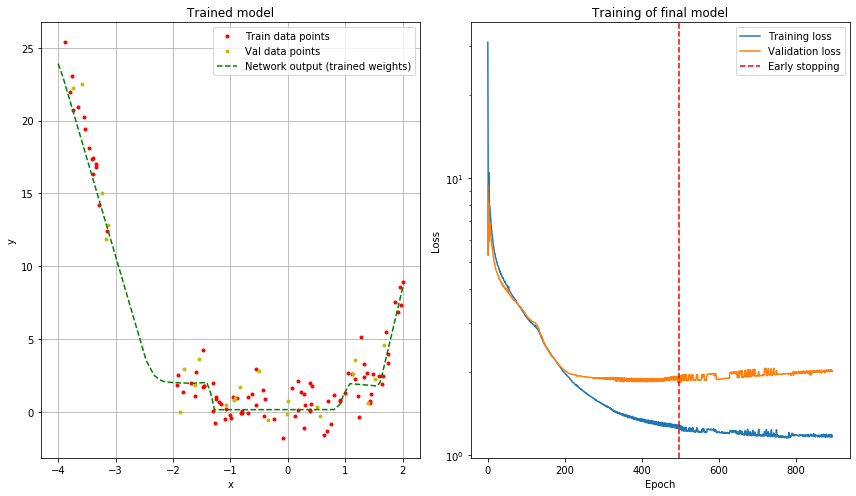

In [16]:
##Plot loss between folds
fig, ax = plt.subplots(1,2, figsize=(12,7))

x_highres = np.linspace(-4, 2, 1000).reshape(-1,1)
net_output = final_net.forward(x_highres)
x_train, y_train = get_XY(train_set)
x_val, y_val = get_XY(val_set)
ax[0].plot(x_train, y_train, color='r', ls='', marker='.', label='Train data points')
ax[0].plot(x_val, y_val, color='y', ls='', marker='.', label='Val data points')
ax[0].plot(x_highres, net_output, color='g', ls='--', label='Network output (trained weights)')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_title("Trained model")
ax[0].grid()
ax[0].legend()

ax[1].semilogy(train_log, label="Training loss")
ax[1].semilogy(val_log, label="Validation loss")
if len(val_log) != Training_pars["n_epochs"]:
    stopped = len(val_log)-Training_pars["patience"]
    ax[1].axvline(stopped, color="r", 
                  label="Early stopping", linestyle= "--")
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title("Training of final model")
ax[1].legend()

fig.tight_layout()
fig.show()    

#EVALUATING FINAL MODEL PERFORMANCES ON TEST SET
y_test_est = final_net.forward(x_test)
test_loss = np.mean((y_test_est - y_test)**2)
print("Train error on final model:", train_err)
print("Validation error on final model:", val_err)
print("Test error on final model:", test_loss)